This notebook investigates the concept of the tunable coupling proposed in the article
[[Yan et al., 2018]](https://journals.aps.org/prapplied/abstract/10.1103/PhysRevApplied.10.054062)
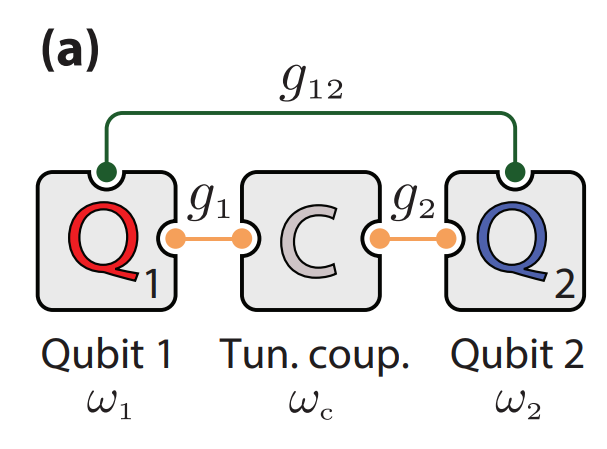

The hamiltonian of the system

\begin{aligned}
\hat{H} & =\sum_{j=1,2} \frac{1}{2} \omega_j \hat{\sigma}_j^z+\frac{1}{2} \omega_{\mathrm{c}} \hat{\sigma}_{\mathrm{c}}^z+\sum_{j=1,2} g_j\left(\hat{\sigma}_j^{+} \hat{\sigma}_{\mathrm{c}}^{-}+\hat{\sigma}_j^{-} \hat{\sigma}_{\mathrm{c}}^{+}\right) +g_{12}\left(\hat{\sigma}_1^{+} \hat{\sigma}_2^{-}+\hat{\sigma}_2^{-} \hat{\sigma}_1^{+}\right)
\end{aligned}

After applying Schrieffer-Wolf transformation $U=\exp \left[\sum_{j=1,2} \frac{g_j}{\Delta_j}\left(\sigma_j^{+} \sigma_{\mathrm{c}}^{-}-\sigma_j^{-} \sigma_{\mathrm{c}}^{+}\right)\right]$, where $\Delta_j = \omega_j - \omega_c$, we will have the following hamiltonian

\begin{equation}
\hat{\widetilde{H}}=\sum_{j=1,2} \frac{1}{2} \widetilde{\omega}_j \hat{\sigma}_j^z+\left[\frac{g_1 g_2}{\Delta}+g_{12}\right]\left(\hat{\sigma}_1^{+} \hat{\sigma}_2^{-}+\hat{\sigma}_2^{-} \hat{\sigma}_1^{+}\right),
\end{equation}
where $ \widetilde{\omega}_j = {\omega}_j + \frac{g_j^2}{\Delta_j}$ and $1/\Delta = (1/\Delta_1 + 1\Delta_2)/2$

We introduce the effective coupling coefficient $g_{eff} = \frac{g_1 g_2}{\Delta}+g_{12}$

In terms of creation and annihilation operators the hamiltonian looks like
\begin{equation}
\hat{\widetilde{H}}=\sum_{j=1,2} \widetilde{\omega}_j \hat{a}_j^{\dagger}\hat{a}_j - \sum_{j=1,2}\frac{1}{2}{\omega}_j  +\left[\frac{g_1 g_2}{\Delta}+g_{12}\right]\left(\hat{\sigma}_1^{+} \hat{\sigma}_2^{-}+\hat{\sigma}_2^{-} \hat{\sigma}_1^{+}\right)
\end{equation}

In [79]:
from math import pi
import numpy as np
from qutip import steadystate, expect, Qobj
import matplotlib.pyplot as plt

import sys
import path
import os
 
sys.path.append(os.path.dirname(os.getcwd()))

from main import QSystem
 

Note: we calculated $g_{12}$ value, using 

In [126]:
# In the next block, we will compute transmission spectre of the system using qutip.steadystate
def spectrum(coupler_frequencies, g1, g2, g12, w1, w2, drive_frequencies):
    gamma = 16e-3  # decay rates, GHz
    Gamma = gamma
    drive_amplitude = 0.1e-2 * 2 * pi
    sparam_all = []
    # effective coupling coefficient
    g_eff = []
    for wc in coupler_frequencies:
        sparam = []
        for w_drive in drive_frequencies:
            frequencies = [[0, w1], [1, wc], [2, w2]]
            couplings = [[1, 0, g1(wc)], [2, 1, g2(wc)], [0, 2, g12(wc)]]
            n_q = len(frequencies)
            single_photon_states = [[0 for _ in range(n_q)], ] + [[1 if j == i else 0 for j in range(n_q)] for i in
                                                                  range(n_q)]  # basis states
            system = QSystem(frequencies, couplings, single_photon_states)  # initialization of the system
            H_full = system.H_matrix() + Qobj(
                np.array([[-w_drive if (i == j and i != 0) else 0 for j in range(len(single_photon_states))] for i in
                          range(len(single_photon_states))])) + drive_amplitude / 2 * (
                             system.annihilation_operator_matrix(0) + system.annihilation_operator_matrix(0).dag())
            final_state = steadystate(H_full, [np.sqrt(gamma) * system.annihilation_operator_matrix(0),
                                               np.sqrt(gamma) * system.annihilation_operator_matrix(2)],
                                      use_precond=True, maxiter=1000, tol=1e-12,
                                      return_info=True)
            s = 2 * Gamma / (1j * drive_amplitude) * expect(Qobj(system.annihilation_operator_matrix(2)).dag(),
                                                            final_state[0])
            sparam.append(s)
        # detection of the moment when coefficient g_eff becomes bigger than zero
        states = system.H_matrix().eigenstates()
        for i in range(len(states[1])):
            if (states[1][i][1].real < 0 and states[1][i][3].real > 0) or (states[1][i][1].real > 0 and states[1][i][3].real < 0):
                antisymmetric_index = i
            elif states[1][i][1].real > 0 and states[1][i][3].real > 0:
                symmetric_index = i
        g_eff.append((states[0][symmetric_index] - states[0][antisymmetric_index]) / 2)
        sparam_all.append(sparam)
    return sparam_all, g_eff


Below, you can see the dependence of the transmission spectra on the coupler frequency 

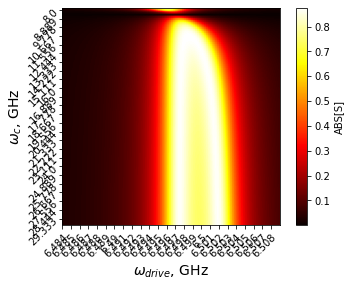

In [128]:
# visualization block
# heatmap: x-axis is driving frequency, y-axis is coupler frequency and color is absolute value of the S-parameter
coupler_frequecies = np.linspace(8, 30, 100) * 2 * pi
drive_frequencies = np.linspace(6.484, 6.509, 100) * 2 * pi
# we introduce these weird constant functions for the to make spectrum(coupler_frequencies, g1, g2, g12) universal
g1 = lambda freq: 80e-3 * 2 * pi
g2 = lambda freq: 80e-3 * 2 * pi
g12 = lambda freq: 3e-3 * 2 * pi
w1 = 6.5*2*pi
w2 = 6.5*2*pi
spec = spectrum(coupler_frequecies, g1, g2, g12, w1, w2, drive_frequencies)
sparam_all = spec[0]
g_eff = spec[1]
plt.imshow(np.abs(np.array(sparam_all)), extent=[0, 100, 0, 100], cmap='hot')
plt.yticks(np.arange(len(coupler_frequecies))[::-4],
           labels=list(map(lambda x: str(round(x / (2 * pi), 3)), coupler_frequecies[::4])), rotation=45, ha="right",
           rotation_mode="anchor")
plt.xticks(np.arange(len(drive_frequencies))[::4],
           labels=list(map(lambda x: str(round(x / (2 * pi), 3)), drive_frequencies[::4])), rotation=45, ha="right",
           rotation_mode="anchor")
plt.xlabel("$\omega_{drive}$, GHz", fontsize=14)
plt.ylabel("$\omega_c$, GHz", fontsize=14)
plt.colorbar(label="ABS[S]")
plt.show()

The comparison of theoretical dependence, got with Schrieffer–Wolff transformation, with numerical calculations


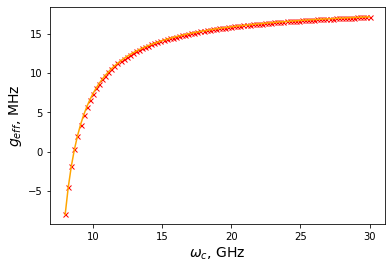

In [129]:
plt.plot(coupler_frequecies / (2 * pi), np.array(g_eff) * 1000, "rx", markersize="5")
plt.plot(coupler_frequecies / (2 * pi), g1(coupler_frequecies) * g2(coupler_frequecies) * 1/2 * (1/(w1 - coupler_frequecies) + 1/(w2 - coupler_frequecies))  * 1000 + g12(coupler_frequecies) * 1000, color="orange")
plt.ylabel("$g_{eff}$, MHz", fontsize=14)
plt.xlabel("$\omega_c$, GHz", fontsize=14)
plt.show()

Note: Due to small values of $g_{eff}$ for $\omega_{drive}$ less than 11 GHz, two resonant peaks are indistinguishable that leads to difficuties in experimental measurements. 

Now, let's take a look at the case when $g_{1}$, $g_{2}$ and $g_{12}$ are obtained by the quantization of the circuit

\begin{equation}
g_j \approx \frac{1}{2} \frac{C_{j \mathrm{c}}}{\sqrt{C_j C_{\mathrm{c}}}} \sqrt{\omega_1 \omega_{\mathrm{c}}}, \quad j=1,2
\end{equation}

\begin{equation}
g_{12} \approx \frac{1}{2}\left[\frac{C_{12}}{\sqrt{C_1 C_2}}+\frac{C_{1 \mathrm{c}} C_{2 \mathrm{c}}}{\sqrt{C_1 C_2 C_{\mathrm{c}}^2}}\right] \sqrt{\omega_1 \omega_2}
\end{equation}

We will use figures, suggested in the article: $\omega_1 = \omega_2 = 4~GHz$, $C_1 = 70~fF$, $C_2 = 72~fF$, $C_c = 200~fF$, $C_{1c} = 4~fF$, $C_{2c} = 4.2~fF$, $C_{12} = 0.1~fF$

In [131]:
w1 = 4
w2 = 4
C1 = 70
C2 = 72
Cc = 200
C1c = 4
C2c = 4.2
C12 = 0.1

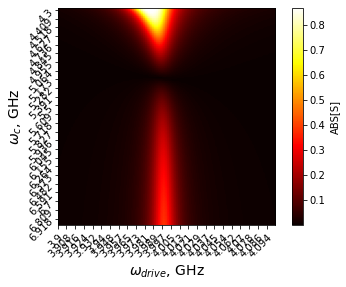

In [137]:
coupler_frequecies = np.linspace(4.3, 7, 100)
drive_frequencies = np.linspace(3.9, 4.1, 100)

# we introduce these weird constant functions for the to make spectrum(coupler_frequencies, g1, g2, g12) universal
g1 = lambda freq: 1/2*C1c/(C1*Cc)**0.5 * (w1*freq)**0.5
g2 = lambda freq: 1/2*C2c/(C2*Cc)**0.5 * (w2*freq)**0.5
g12 = lambda freq: 1/2*(C12/(C1*C2)**0.5 + C1c*C2c/(C1*C2*Cc**2)**0.5)*(w1*w2)**0.5

spec = spectrum(coupler_frequecies, g1, g2, g12, w1, w2, drive_frequencies)
sparam_all = spec[0]
g_eff = spec[1]
plt.imshow(np.abs(np.array(sparam_all)), extent=[0, 100, 0, 100], cmap='hot')
plt.yticks(np.arange(len(coupler_frequecies))[::-4],
           labels=list(map(lambda x: str(round(x, 3)), coupler_frequecies[::4])), rotation=45, ha="right",
           rotation_mode="anchor")
plt.xticks(np.arange(len(drive_frequencies))[::4],
           labels=list(map(lambda x: str(round(x, 3)), drive_frequencies[::4])), rotation=45, ha="right",
           rotation_mode="anchor")
plt.xlabel("$\omega_{drive}$, GHz", fontsize=14)
plt.ylabel("$\omega_c$, GHz", fontsize=14)
plt.colorbar(label="ABS[S]")
plt.show()

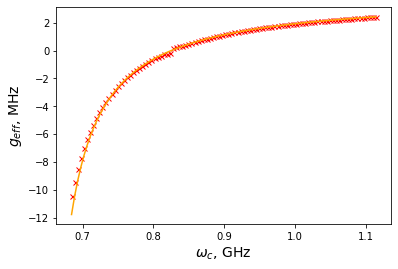

In [138]:
plt.plot(coupler_frequecies / (2 * pi), np.array(g_eff) * 1000, "rx", markersize="5")
plt.plot(coupler_frequecies / (2 * pi), g1(coupler_frequecies) * g2(coupler_frequecies) * 1/2 * (1/(w1 - coupler_frequecies) + 1/(w2 - coupler_frequecies))  * 1000 + g12(coupler_frequecies) * 1000, color="orange")
plt.ylabel("$g_{eff}$, MHz", fontsize=14)
plt.xlabel("$\omega_c$, GHz", fontsize=14)
plt.show()